In [1]:
cd ../..

/home/asingal/home/quisp/SeQUeNCe_quisp


/home/asingal/home/.venv/lib/python3.10/site-packages/IPython/core/magics/osm.py:417: UserWarning: This is now an optional IPython functionality, setting dhist requires you to install the `pickleshare` library.
  self.shell.db['dhist'] = compress_dhist(dhist)[-100:]


In [2]:
import numpy as np
import pandas as pd
import time
from matplotlib import pyplot as plt

from src.topology.router_net_topo import RouterNetTopo
from src.app.request_app import RequestApp
from src.utils import log


## Validating measurement fidelity simulations
Simulation script

In [3]:
def meas_fid_sim(meas_fidelities, coherence_times):
    CONFIG_FILE = "example/SC24/config_files/swap.json"
    LOG_OUTPUT = "example/SC24/meas_log.txt"

    # meta params
    NO_TRIALS = 100
    LOGGING = False
    MODULE_TO_LOG = ["timeline", "memory", "bsm", "generation", "request_app", "optical_channel", "resource_manager"]

    # simulation params
    PREP_TIME = int(1e12)  # 1 second
    COLLECT_TIME = int(1e11)  # 3.1, 10 seconds

    # qc params
    QC_FREQ = 1e11
    total_distance = 20  # (unit: km)

    print("meas_fidelities:", meas_fidelities)


    # application params
    APP_NODE_NAME = "left"
    OTHER_NODE_NAME = "right"
    num_memo = 1

    # storing data
    data_dict = {"Distance": [],
                "Average Throughput": [],
                "Std. Throughput": [],
                "Average_TTT": [],
                "probs":[]}


    fidelity_by_coherence = []
    for coherence_time in coherence_times:
        tick = time.time()
        meas_swapped_fidelities_decoherence = []
        for i, meas_fidelity in enumerate(meas_fidelities):
            print(f"Running {NO_TRIALS} trials for distance {meas_fidelity}km ({i + 1}/{len(meas_fidelities)})")
            data_dict["Distance"].append(meas_fidelity)
            throughputs = np.zeros(NO_TRIALS)
            time_to_thousand = np.zeros(NO_TRIALS)
            probs = np.zeros(NO_TRIALS)
            temp_fidelities = []

            for trial_no in range(NO_TRIALS):
                # establish network
                net_topo = RouterNetTopo(CONFIG_FILE)

                # timeline setup
                tl = net_topo.get_timeline()
                tl.stop_time = PREP_TIME + COLLECT_TIME

                # Logging stuff
                if LOGGING:
                    # set log
                    if i == 3:
                        log.set_logger(__name__, tl, LOG_OUTPUT)
                        log.set_logger_level('WARN')
                        for module in MODULE_TO_LOG:
                            log.track_module(module)
                    elif i == 4:
                        for module in MODULE_TO_LOG:
                            log.remove_module(module)

                # network configuration
                routers = net_topo.get_nodes_by_type(RouterNetTopo.QUANTUM_ROUTER)
                bsm_nodes = net_topo.get_nodes_by_type(RouterNetTopo.BSM_NODE)

                for j, node in enumerate(routers + bsm_nodes):
                    node.set_seed(j + (trial_no * 3))

                # set meas fidelities
                for router in routers:
                    router.meas_fid = meas_fidelity
                        
                # establish app on left node
                start_node = None
                for node in routers:
                    if node.name == APP_NODE_NAME:
                        start_node = node
                        break
                if not start_node:
                    raise ValueError(f"Invalid app node name {APP_NODE_NAME}")
                end_node = None
                for node in routers:
                    for memory in node.memory_array.memories:
                        memory.coherence_time = coherence_time
                        memory.decoherence_rate = 1/memory.coherence_time 
                    if node.name == OTHER_NODE_NAME:
                        end_node = node
                        break
                if not start_node:
                    raise ValueError(f"Invalid other node name {OTHER_NODE_NAME}")

                app_start = RequestApp(start_node)
                app_end = RequestApp(end_node)

                tl.init()
                app_start.start(OTHER_NODE_NAME, PREP_TIME, PREP_TIME + COLLECT_TIME, num_memo, 1)
                tl.run()
                temp_fidelities.append(routers[0].new_fidelity)
            meas_swapped_fidelities_decoherence.append(np.mean(temp_fidelities))
            print("Finished trials.")
        fidelity_by_coherence.append(meas_swapped_fidelities_decoherence)
    return fidelity_by_coherence


In [4]:
meas_fidelities = np.linspace(1,0.05,int(0.975/0.05)+1)
meas_errors = [1-i for i in meas_fidelities]

In [5]:
coherence_times = np.array([18, 30, 55, -1000])
coherence_times = coherence_times * 1e-3

fidelity_by_coherence = meas_fid_sim(meas_fidelities, coherence_times)

meas_fidelities: [1.   0.95 0.9  0.85 0.8  0.75 0.7  0.65 0.6  0.55 0.5  0.45 0.4  0.35
 0.3  0.25 0.2  0.15 0.1  0.05]
Running 100 trials for distance 1.0km (1/20)
Finished trials.
Running 100 trials for distance 0.95km (2/20)
Finished trials.
Running 100 trials for distance 0.9km (3/20)
Finished trials.
Running 100 trials for distance 0.85km (4/20)
Finished trials.
Running 100 trials for distance 0.8km (5/20)
Finished trials.
Running 100 trials for distance 0.75km (6/20)
Finished trials.
Running 100 trials for distance 0.7km (7/20)
Finished trials.
Running 100 trials for distance 0.65km (8/20)
Finished trials.
Running 100 trials for distance 0.6000000000000001km (9/20)
Finished trials.
Running 100 trials for distance 0.55km (10/20)
Finished trials.
Running 100 trials for distance 0.5km (11/20)
Finished trials.
Running 100 trials for distance 0.45000000000000007km (12/20)
Finished trials.
Running 100 trials for distance 0.4km (13/20)
Finished trials.
Running 100 trials for distance 0.

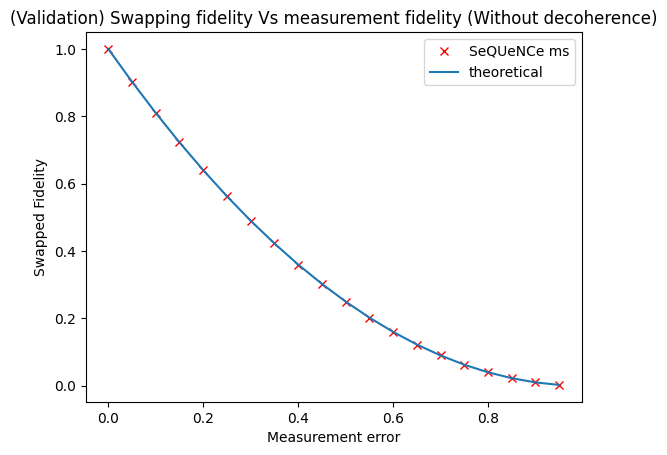

In [6]:
decohere = lambda data,coherence_time,t: data*np.exp(-2*t/coherence_time) + (1-np.exp(-2*t/coherence_time))/4
swap_fidelity_perfect_meas = lambda p,f1,f2: ((1-p)/4) + p*(f1*f2 + (1-f1)*(1-f2)/3)
swap_fidelity = lambda p,n,f1,f2: ((1-p)/4) + p*(n**2)*(f1*f2 + (1-f1)*(1-f2)/3)+(1-n**2)*((f1*(1-f2)/3) + (f2*(1-f1)/3) + 2*(1-f1)*(1-f2)/9)

generation_fidelity = np.ones(len(meas_fidelities))
theoretical_data = swap_fidelity(1, meas_fidelities, generation_fidelity, generation_fidelity)


plt.title("(Validation) Swapping fidelity Vs measurement fidelity (Without decoherence)")
plt.xlabel("Measurement error")
plt.ylabel("Swapped Fidelity")
plt.plot(meas_errors, fidelity_by_coherence[3], 'rx', label = f"SeQUeNCe ms")
plt.plot(meas_errors, theoretical_data, label="theoretical")
plt.legend()

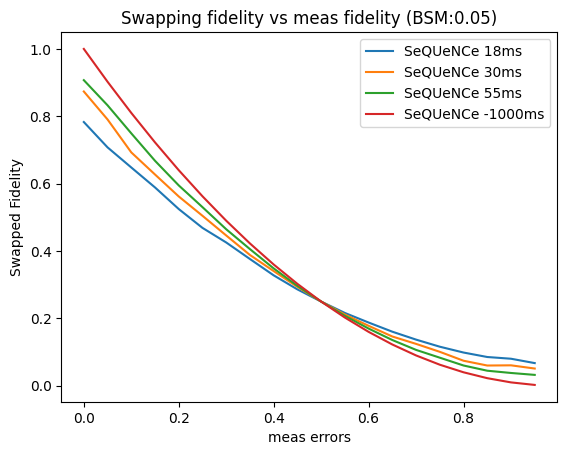

In [7]:
for i in range(len(fidelity_by_coherence)):
    plt.plot(meas_errors, fidelity_by_coherence[i], label = f"SeQUeNCe {int(coherence_times[i]*1e3)}ms")

plt.title("Swapping fidelity vs meas fidelity (BSM:0.05)")
plt.xlabel("meas errors")
plt.ylabel("Swapped Fidelity")
plt.legend()

[0.0, 0.025000000000000022, 0.050000000000000044, 0.07499999999999996, 0.09999999999999998, 0.125, 0.15000000000000002, 0.17500000000000004, 0.19999999999999996, 0.22499999999999998, 0.25, 0.2749999999999999, 0.30000000000000004, 0.32499999999999996, 0.35, 0.375, 0.3999999999999999, 0.42500000000000004, 0.44999999999999996, 0.475, 0.5, 0.5249999999999999, 0.5499999999999999, 0.575, 0.6, 0.625, 0.6499999999999999, 0.6749999999999999, 0.7, 0.725, 0.7499999999999999, 0.7749999999999999, 0.7999999999999999, 0.825, 0.85, 0.8749999999999999, 0.8999999999999999, 0.9249999999999999, 0.95, 0.975]


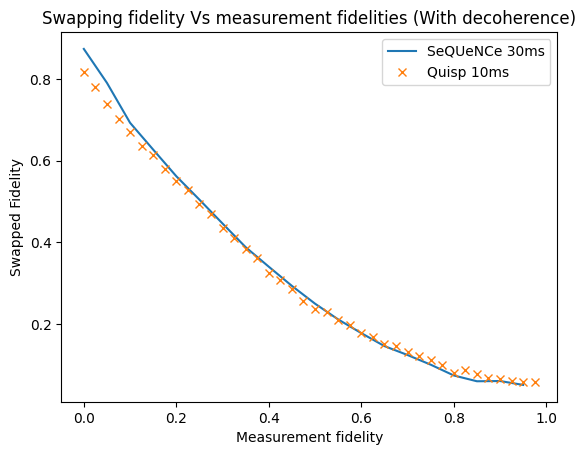

In [8]:
csvfile = open('example/SC24/quisp_data/quisp_10ms_error.csv','r') 
df = pd.read_csv(csvfile)
Quisp_fidelities = list(df["Quisp_10ms_meas"])
quisp_meas_fidelities = np.linspace(1,0.025,int(0.975/0.025)+1)
quisp_meas_errors = [1-i for i in quisp_meas_fidelities]

print(quisp_meas_errors)

plt.title("Swapping fidelity Vs measurement fidelities (With decoherence)")
plt.xlabel("Measurement fidelity")
plt.ylabel("Swapped Fidelity")
# for i in range(len(fidelity_by_coherence)):
#     plt.plot(meas_errors, fidelity_by_coherence[i], label = f"SeQUeNCe {int(coherence_times[i]*1e3)}ms")
plt.plot(meas_errors, fidelity_by_coherence[1], label = f"SeQUeNCe {int(coherence_times[1]*1e3)}ms")
plt.plot(quisp_meas_errors, Quisp_fidelities, 'x', label = "Quisp 10ms",)
plt.legend()
length = len(fidelity_by_coherence[0])
# plt.xticks(list(range(0,41,4)), [i/10 for i in list(range(10,-1, -1))])


### Varying Gate fidelities

In [9]:
def gate_fid_sim(gate_fidelities, coherence_times):
    CONFIG_FILE = "example/SC24/config_files/swap.json"
    LOG_OUTPUT = "example/SC24/gate_log.txt"

    # meta params
    NO_TRIALS = 100
    LOGGING = False
    MODULE_TO_LOG = ["timeline", "memory", "bsm", "generation", "request_app", "optical_channel", "resource_manager"]

    # simulation params
    PREP_TIME = int(1e12)  # 1 second
    COLLECT_TIME = int(1e11)  # 3.1, 10 seconds

    # qc params
    QC_FREQ = 1e11
    total_distance = 20  # (unit: km)

    print("gate_fidelities:", gate_fidelities)


    # application params
    APP_NODE_NAME = "left"
    OTHER_NODE_NAME = "right"
    num_memo = 1

    # storing data
    data_dict = {"Distance": [],
                "Average Throughput": [],
                "Std. Throughput": [],
                "Average_TTT": [],
                "probs":[]}


    fidelity_by_coherence = []
    for coherence_time in coherence_times:
        tick = time.time()
        gate_swapped_fidelities_decoherence = []
        for i, gate_fidelity in enumerate(gate_fidelities):
            print(f"Running {NO_TRIALS} trials for distance {gate_fidelity}km ({i + 1}/{len(gate_fidelities)})")
            data_dict["Distance"].append(gate_fidelity)
            throughputs = np.zeros(NO_TRIALS)
            time_to_thousand = np.zeros(NO_TRIALS)
            probs = np.zeros(NO_TRIALS)
            temp_fidelities = []

            for trial_no in range(NO_TRIALS):
                # establish network
                net_topo = RouterNetTopo(CONFIG_FILE)

                # timeline setup
                tl = net_topo.get_timeline()
                tl.stop_time = PREP_TIME + COLLECT_TIME

                # Logging stuff
                if LOGGING:
                    # set log
                    if i == 3:
                        log.set_logger(__name__, tl, LOG_OUTPUT)
                        log.set_logger_level('WARN')
                        for module in MODULE_TO_LOG:
                            log.track_module(module)
                    elif i == 4:
                        for module in MODULE_TO_LOG:
                            log.remove_module(module)

                # network configuration
                routers = net_topo.get_nodes_by_type(RouterNetTopo.QUANTUM_ROUTER)
                bsm_nodes = net_topo.get_nodes_by_type(RouterNetTopo.BSM_NODE)

                for j, node in enumerate(routers + bsm_nodes):
                    node.set_seed(j + (trial_no * 3))

                # set gate fidelities
                for router in routers:
                    router.gate_fid = gate_fidelity
                        
                # establish app on left node
                start_node = None
                for node in routers:
                    if node.name == APP_NODE_NAME:
                        start_node = node
                        break
                if not start_node:
                    raise ValueError(f"Invalid app node name {APP_NODE_NAME}")
                end_node = None
                for node in routers:
                    for memory in node.memory_array.memories:
                        memory.coherence_time = coherence_time
                        memory.decoherence_rate = 1/memory.coherence_time 
                    if node.name == OTHER_NODE_NAME:
                        end_node = node
                        break
                if not start_node:
                    raise ValueError(f"Invalid other node name {OTHER_NODE_NAME}")

                app_start = RequestApp(start_node)
                app_end = RequestApp(end_node)

                tl.init()
                app_start.start(OTHER_NODE_NAME, PREP_TIME, PREP_TIME + COLLECT_TIME, num_memo, 1)
                tl.run()
                temp_fidelities.append(routers[0].new_fidelity)
            gate_swapped_fidelities_decoherence.append(np.mean(temp_fidelities))
            print("Finished trials.")
        fidelity_by_coherence.append(gate_swapped_fidelities_decoherence)
    return fidelity_by_coherence


In [10]:
gate_fidelities = np.linspace(1,0,int(1/0.05)+1)
gate_errors = [1-i for i in gate_fidelities]

In [11]:
coherence_times = np.array([18, 30, 55, -1000])
coherence_times = coherence_times * 1e-3

fidelity_by_coherence = gate_fid_sim(gate_fidelities, coherence_times)

gate_fidelities: [1.   0.95 0.9  0.85 0.8  0.75 0.7  0.65 0.6  0.55 0.5  0.45 0.4  0.35
 0.3  0.25 0.2  0.15 0.1  0.05 0.  ]
Running 100 trials for distance 1.0km (1/21)
Finished trials.
Running 100 trials for distance 0.95km (2/21)
Finished trials.
Running 100 trials for distance 0.9km (3/21)
Finished trials.
Running 100 trials for distance 0.85km (4/21)
Finished trials.
Running 100 trials for distance 0.8km (5/21)
Finished trials.
Running 100 trials for distance 0.75km (6/21)
Finished trials.
Running 100 trials for distance 0.7km (7/21)
Finished trials.
Running 100 trials for distance 0.6499999999999999km (8/21)
Finished trials.
Running 100 trials for distance 0.6km (9/21)
Finished trials.
Running 100 trials for distance 0.55km (10/21)
Finished trials.
Running 100 trials for distance 0.5km (11/21)
Finished trials.
Running 100 trials for distance 0.44999999999999996km (12/21)
Finished trials.
Running 100 trials for distance 0.3999999999999999km (13/21)
Finished trials.
Running 100 tri

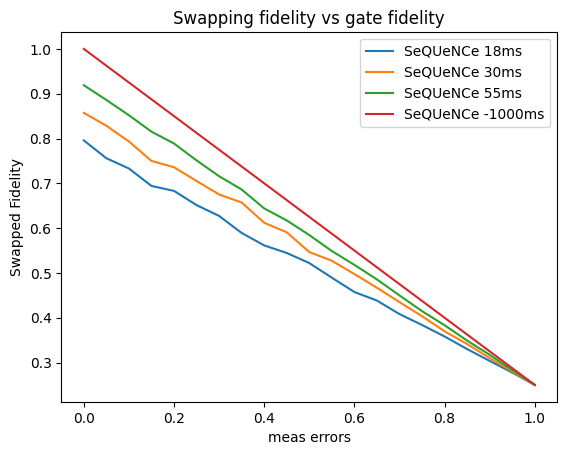

In [12]:
for i in range(len(fidelity_by_coherence)):
    plt.plot(gate_errors, fidelity_by_coherence[i], label = f"SeQUeNCe {int(coherence_times[i]*1e3)}ms")

plt.title("Swapping fidelity vs gate fidelity")
plt.xlabel("meas errors")
plt.ylabel("Swapped Fidelity")
plt.legend()

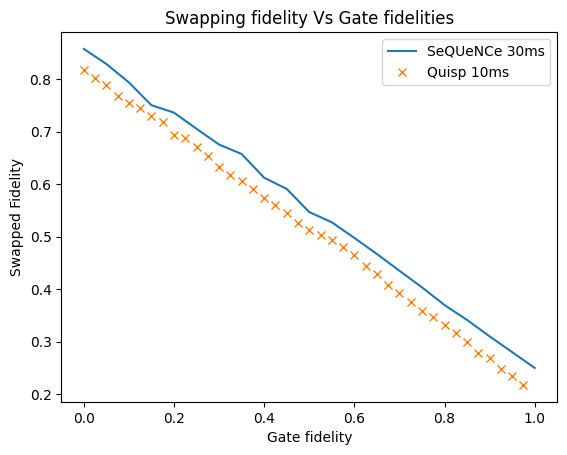

In [13]:
gate_fidelities = np.linspace(1,0.05,int(0.975/0.05)+1)

csvfile = open('example/SC24/quisp_data/Quisp_15_error.csv','r') 
df = pd.read_csv(csvfile)
Quisp_fidelities = list(df["10ms "])

plt.title("Swapping fidelity Vs Gate fidelities")
plt.xlabel("Gate fidelity")
plt.ylabel("Swapped Fidelity")
# for i in range(len(fidelity_by_coherence)):
# plt.plot(sequence_data, label = f"SeQUeNCe {int(coherence_times[0]*1e3)}ms")
plt.plot(gate_errors, fidelity_by_coherence[1], label = f"SeQUeNCe {int(coherence_times[1]*1e3)}ms")
plt.plot(quisp_meas_errors, Quisp_fidelities, 'x', label = "Quisp 10ms",)
# plt.plot(Quisp_fidelities, 'x', label = "Quisp 10ms",)
plt.legend()